# Physics 411

# Assignment 7

### Q1: Frequency-domain filtering

Consider a time series with a sharp jump in the middle as in the notes:

In [81]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib nbagg

N=1001
dt=1.
t=np.arange(0,N*dt,dt)

x = np.cumsum(np.random.randn(N)) # red noise
f0 = 0.03 # Hz
x = x + 40.*np.sin(f0*2*np.pi*t) # + sine wave
x = x - np.mean(x)
noise = 60.*np.random.randn(N)
xn = x+noise
xn[N/2:]=xn[N/2:]-2000.
# remove the mean!!
xn = xn-np.mean(xn)

**1** Implement a low-pass filter of the data in the frequency domain, with a cutoff frequency of $f_c=0.06 Hz$.

1. plot the signal and the smoothed signal (suggest zooming in on the step).
2. plot the spectral response $|H(f)|$
3. plot the phase response $angle(H(f))$.

Be sure to comment on how good your filter is.

<IPython.core.display.Javascript object>


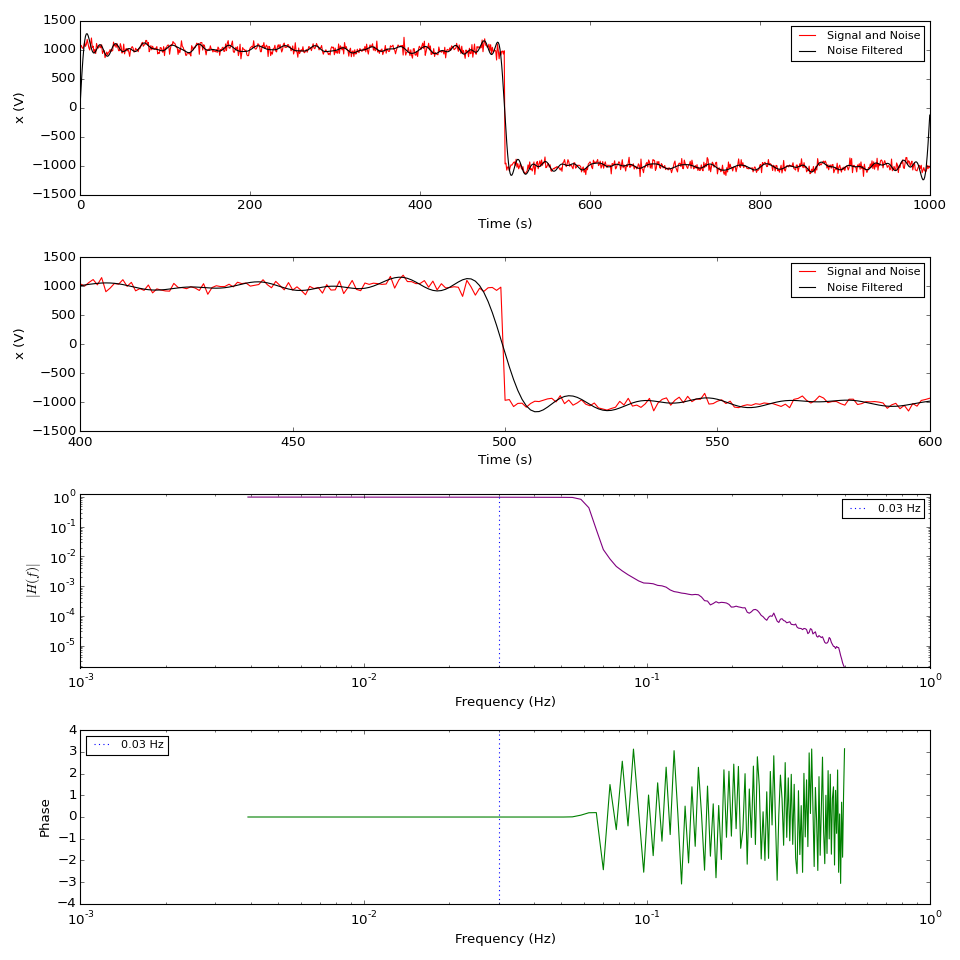

In [120]:
#filtering noise above 0.06Hz
nfft=128*2
args = {'NFFT':nfft,'Fs':1./dt,'noverlap':nfft/2.,'window':mlab.window_hanning}

#Used to Create a filtered signal of 0.06Hz
X = np.fft.fft(xn)
ff = np.linspace(0,1./dt,N)
fc= 0.06
X[(ff>fc) & (ff<(1./dt - fc))]=1.e-15
y = np.real(np.fft.ifft(X))

Gxy, fxy = mlab.csd(y,xn,**args)
Px, f = mlab.psd(x,**args)
Pn, f = mlab.psd(noise,**args)
Py, f = mlab.psd(y,**args)
Pxn, f = mlab.psd(xn,**args)

fig,ax=plt.subplots(4,1,figsize=(12,12))
ax[0].plot(t,xn,'r', label='Signal and Noise')
ax[0].plot(t,y,'k', label='Noise Filtered')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('x (V)')
ax[0].legend(loc='best', fontsize='small')

ax[1].plot(t,xn,'r', label='Signal and Noise')
ax[1].plot(t,y,'k', label='Noise Filtered')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('x (V)')
ax[1].set_xlim(400,600)
ax[1].legend(loc='best', fontsize='small')

H = np.sqrt(Py / (Pxn+Pn))
ax[2].loglog(f,H,color='purple')
ax[2].axvline(0.03, label='0.03 Hz', linestyle=':')
ax[2].set_ylim(0,1.3)
ax[2].set_ylabel(r'$|H(f)|$')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].legend(loc='best', fontsize='small')

ax[3].semilogx(f, np.angle(Gxy), color='green')
ax[3].axvline(0.03, label='0.03 Hz', linestyle=':')
ax[3].set_ylabel('Phase')
ax[3].set_xlabel('Frequency (Hz)')
ax[3].legend(loc='best', fontsize='small')
plt.tight_layout()

The low-pass filter did an alright job; however, it did jump off the sharp jump a bit earlier than the original unfiltered function. The noise was definitely reduced, and low frequencies were retained while the higher frequencies were removed for the most part.

**2** Now repeat the above but apply a Hanning window to the frequency window *before* you apply it to the FFT of $x_n$. Comment on how well the filter is doing when you do this. (Its helpful to keep the previous result up) (It is OK to use the `hanning` function)

<IPython.core.display.Javascript object>


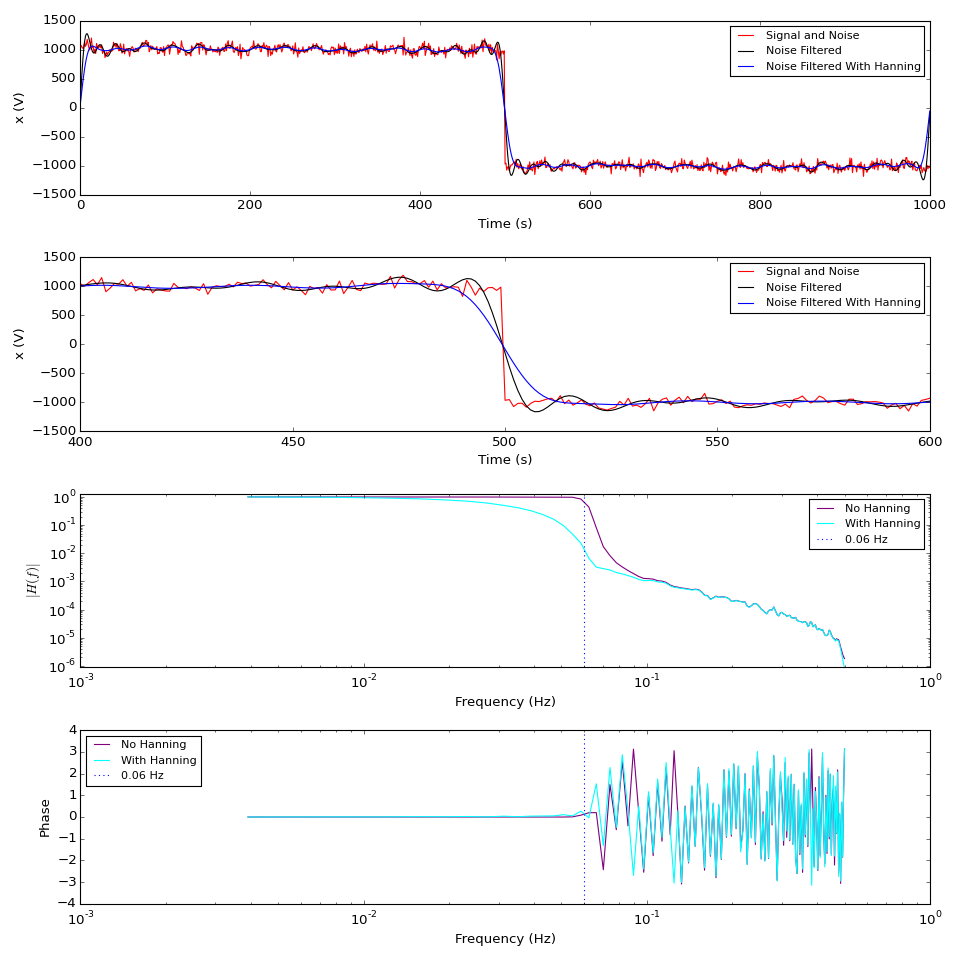

In [121]:
K = f.size
fn = ff * 0. + 1e-15
fn[(ff<fc)] = 1. 
fn[(ff > 1-fc)] = 1.
han = np.hanning(K)
fn[:K/2] = fn[:K/2] * han[K/2+1:]
fn[N-K/2:] = fn[N-K/2:] * han[:K/2]

Hy = np.real(np.fft.ifft(X*fn))

GxHy, fxHy = mlab.csd(Hy,xn,**args)
PHy, fHy = mlab.psd(Hy,**args)
HHy = np.sqrt(PHy / (Pxn+Pn))


fig,ax=plt.subplots(4,1,figsize=(12,12))
ax[0].plot(t,xn,'r', label='Signal and Noise')
ax[0].plot(t,y,'k', label='Noise Filtered')
ax[0].plot(t,Hy,'b', label='Noise Filtered With Hanning')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('x (V)')
ax[0].legend(loc='best', fontsize='small')

ax[1].plot(t,xn,'r', label='Signal and Noise')
ax[1].plot(t,y,'k', label='Noise Filtered')
ax[1].plot(t,Hy,'b', label='Noise Filtered With Hanning')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('x (V)')
ax[1].set_xlim(400,600)
ax[1].legend(loc='best', fontsize='small')


ax[2].loglog(f,H,color='purple', label='No Hanning')
ax[2].loglog(fHy,HHy,color='cyan', label='With Hanning')
ax[2].axvline(0.06, label='0.06 Hz', linestyle=':')
ax[2].set_ylim(0,1.3)
ax[2].set_ylabel(r'$|H(f)|$')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].legend(loc='best', fontsize='small')

ax[3].semilogx(f, np.angle(Gxy), color='purple', label='No Hanning')
ax[3].semilogx(fHy, np.angle(GxHy), color='cyan', label='With Hanning')
ax[3].axvline(0.06, label='0.06 Hz', linestyle=':')
ax[3].set_ylabel('Phase')
ax[3].set_xlabel('Frequency (Hz)')
ax[3].legend(loc='best', fontsize='small')
plt.tight_layout()

The Hanning Window jumped off the sharp edge sooner than the filter with no Hanning Window. It did reduce the nosie more effectively than the filter from before. It did not reduce the higher frequencies as much as the other filter did though as can be seen in the third graph.

**3** So the Hanning window falls off a *lot* earlier and more slowly than a step function, so adjust the cutoff frequency to get a reasonable filter that preserves the amplitude of the sine wave at $f=0.03 Hz$. Comment on the pros and cons of this approach.

In [117]:
K2 = 2*f.size
fc2 = 2*fc
fn2 = ff * 0. + 1e-15
fn2[(ff<fc2)] = 1. 
fn2[(ff > 1-fc2)] = 1.
han = np.hanning(K2)
fn2[:K2/2] = fn2[:K2/2] * han[K2/2:]
fn2[N-K2/2:] = fn3[N-K2/2:] * han[:K2/2]

H2y = np.real(np.fft.ifft(X*fn2))

GxH2y, fxH2y = mlab.csd(H2y,xn,**args)
PH2y, fH2y = mlab.psd(H2y,**args)
HH2y = np.sqrt(PH2y / (Pxn+Pn))

<IPython.core.display.Javascript object>


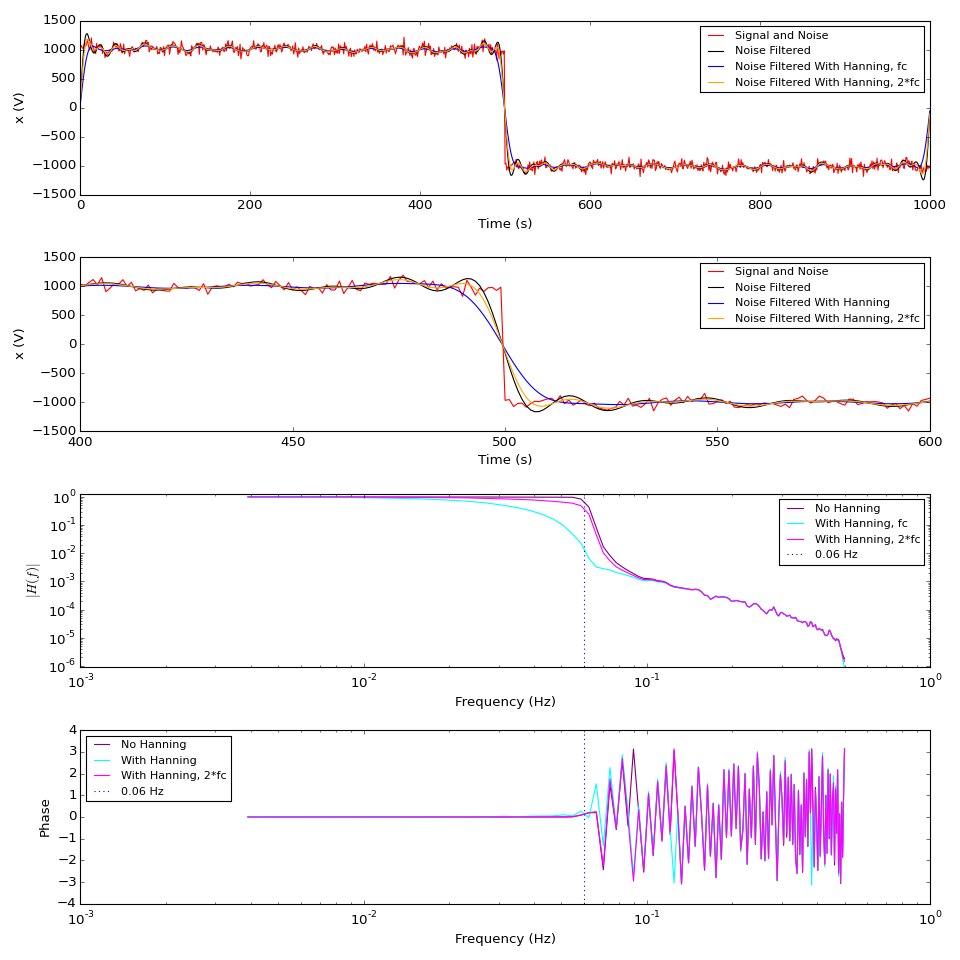

In [122]:
fig,ax=plt.subplots(4,1,figsize=(12,12))
ax[0].plot(t,xn,'r', label='Signal and Noise')
ax[0].plot(t,y,'k', label='Noise Filtered')
ax[0].plot(t,Hy,'b', label='Noise Filtered With Hanning, fc')
ax[0].plot(t,H2y,'orange', label='Noise Filtered With Hanning, 2*fc')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('x (V)')
ax[0].legend(loc='best', fontsize='small')

ax[1].plot(t,xn,'r', label='Signal and Noise')
ax[1].plot(t,y,'k', label='Noise Filtered')
ax[1].plot(t,Hy,'b', label='Noise Filtered With Hanning')
ax[1].plot(t,H2y,'orange', label='Noise Filtered With Hanning, 2*fc')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('x (V)')
ax[1].set_xlim(400,600)
ax[1].legend(loc='best', fontsize='small')


ax[2].loglog(f,H,color='purple', label='No Hanning')
ax[2].loglog(fHy,HHy,color='cyan', label='With Hanning, fc')
ax[2].loglog(fH2y,HH2y,color='magenta', label='With Hanning, 2*fc')
ax[2].axvline(0.06, label='0.06 Hz', linestyle=':')
ax[2].set_ylim(0,1.3)
ax[2].set_ylabel(r'$|H(f)|$')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].legend(loc='best', fontsize='small')

ax[3].semilogx(f, np.angle(Gxy), color='purple', label='No Hanning')
ax[3].semilogx(fHy, np.angle(GxHy), color='cyan', label='With Hanning')
ax[3].semilogx(fH2y, np.angle(GxH2y), color='magenta', label='With Hanning, 2*fc')
ax[3].axvline(0.06, label='0.06 Hz', linestyle=':')
ax[3].set_ylabel('Phase')
ax[3].set_xlabel('Frequency (Hz)')
ax[3].legend(loc='best', fontsize='small')
plt.tight_layout()

A cut-off frequency of 0.12Hz was used for the new filter and gave both pros and cons of both methods used before. The pros were that it did reduce the noise and very little ripple was observed. It also help preserve the lower frequencies and removed the higher ones. In contrast though, it jumped off a bit too early on the sharp edge and it did not entirely reduce higher frequencies.

### Q2: Implementing a bandpass filter

**1** Create a red-noise process with 20000 data points, $dt=1 s$. Using a **truncated Dirichlet Kernel**, create a **bandpass** filter centered at $f_c=0.1 Hz$ that has a passband that is approximately 0.1 Hz wide. Choose a filter length that is long enough to accomodate $0.1 Hz$.

1. Plot the unshifted and shifted filters versus $k$, the time index.
2. Plot the spectra, the response function $H^2(f)$ and the phase response
3. Comment on your bandpass and if it indeed passed the right frequencies.

HINT: when you make the Dirichlet Kernel filter make sure that the $k=0$ case is treated "correctly" because $\sin(0)=0$ and you will get a discontinuity. Calculate what $h_0$ should be from L'Hôpital's_rule.

In [250]:
N = 20000
t = np.arange(N*1.)
x = np.cumsum(np.random.randn(N))
x = x - np.mean(x)
fc = 0.1
K = N/10 #filter length
Gx,fx = mlab.psd(x,**args)

M = fc*2*N+1
k = np.arange(-N/2+1,N/2)
#m = np.linspace(-0.5, 0.5, N+1)
m = np.linspace(-0.5, 0.5, N-1)

h = (1./N/2) * np.sin(np.pi * (k + 0.000001) * M/N/2) / np.sin(np.pi * (k + 0.000001) /N/2)
h1 = h
h1[(np.abs(k) > (K-1)/2)] = 0. 
H1 = np.fft.fftshift(np.fft.fft(h1))
y1 = np.real(np.fft.ifft(H1))

Gy1, fy1 = mlab.psd(y1,**args)
G1, f = mlab.csd(x,y1,**args)
HH1 = Gy1/Gx

m2 = N * .1
h2 = 2 * h * np.cos(2 * np.pi * m2 * k / N) 
H2 = np.fft.fftshift(np.fft.fft(h2))
y2 = np.real(np.fft.ifft(H2))

Gy2, fy2 = mlab.psd(y2,**args)
G2, f = mlab.csd(x,y2,**args)
HH2 = Gy2/Gx
print 'Yay'

Yay


<IPython.core.display.Javascript object>


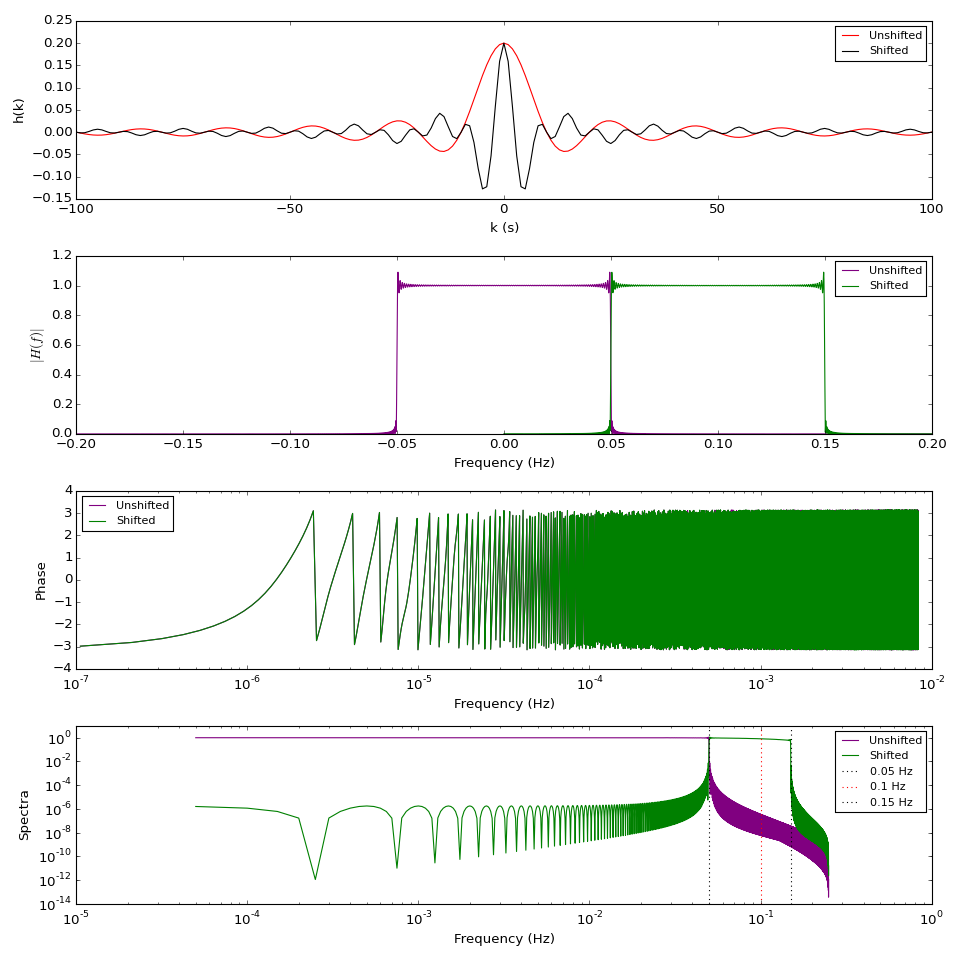

In [254]:
fig,ax=plt.subplots(4,1,figsize=(12,12))
ax[0].plot(k,2*h1,'r', label='Unshifted')
ax[0].plot(k,h2,'k', label='Shifted')
ax[0].set_xlabel('k (s)')
ax[0].set_xlim(-100,100)
ax[0].set_ylabel('h(k)')
ax[0].legend(loc='best', fontsize='small')

ax[1].plot(m,abs(H1),color='purple', label='Unshifted')
ax[1].plot(m[m>0],abs(H2[m>0]),color='green', label='Shifted')
ax[1].set_xlim(-0.2,0.2)
ax[1].set_ylabel(r'$|H(f)|$')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].legend(loc='best', fontsize='small')

ax[2].semilogx(f, np.angle(G1), color='purple', label='Unshifted')
ax[2].semilogx(f, np.angle(G2), color='green', label='Shifted')
ax[2].set_ylabel('Phase')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].legend(loc='best', fontsize='small')

ax[3].loglog(m, H1**2, color='purple', label='Unshifted')
ax[3].loglog(m, H2**2, color='green', label='Shifted')
ax[3].axvline(0.05, label='0.05 Hz', linestyle=':', color='k')
ax[3].axvline(0.1, label='0.1 Hz', linestyle=':', color='r')
ax[3].axvline(0.15, label='0.15 Hz', linestyle=':', color='k')
ax[3].set_ylabel('Spectra')
ax[3].set_xlabel('Frequency (Hz)')
ax[3].legend(loc='best', fontsize='small')

plt.tight_layout()

The bandpass filter did exactly as was planned, it centred itself around 0.1Hz, and has a length of 0.1Hz, extending from 0.05HZ to 0.15Hz, as can be seen in the seond graph. It can also be seen that in the fourth graph, that only frequencies between 0.05Hz and 0.15Hz were preserved while all other frequencies were removed as best as they could be.

### Q3: Bandpass the weather data

In [163]:
minutedata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/MinuteData/DeepCoveNew.txt')[:,1]

dc=minutedata[np.isfinite(minutedata)]
import scipy.signal as signal
dc = dc - np.mean(dc)

**1** Using `signal.filtfilt` and suitable "elliptical" filters band-pass the daily signal from the minute-data from Deep Cove. Plot the power spectrum of the unfiltered and filtered signals.

HINT: Do a high pass and low pass. Design using `ellipord` and `ellip`. These functions allow you to try and design a bandpass directly, but I could not get it to work. Do not be too draconian in your passband - i.e. make it relatively broad, but do try and suppress the peaks. I found it easier to think in terms of "hours" rather than frequencies, but you can do it as frequencies as well.

In [200]:
N = dc.size
fs = 1/60.
fNyq = fs/2.
nfft = N/10
args = {'NFFT':nfft,'Fs':fs,'noverlap':nfft/2.,'window':mlab.window_hanning}

sec = 24.*60.*60.
f = 1./sec

fp = f + f/2
fs = f + f
n,fn=signal.ellipord(fp/fNyq, fs/fNyq,.1, 40.)
b,a=signal.ellip(n,.1,40.,fn,btype='lowpass')
y = signal.filtfilt(b,a,dc)

ffp = f - f/4
ffs = f - f/2
nn,ffn=signal.ellipord(ffp/fNyq, ffs/fNyq,.1, 40.)
bb,aa=signal.ellip(nn,.1,40.,ffn,btype='highpass')
yy = signal.filtfilt(bb,aa,dc)

yyy = signal.filtfilt(bb,aa,y)
#y4 = signal.filtfilt(a,b,y+yy)
#y5 = signal.filtfilt(aa,bb,y+yy)
#y6 = signal.filtfilt(a,b,yy)
print 'done'

done


In [201]:
G, f = mlab.psd(dc, **args)
#G1, f1 = mlab.psd(y, **args)
#G2, f2 = mlab.psd(yy, **args)
G3, f3 = mlab.psd(yyy, **args)
#G4, f4 = mlab.psd(y4, **args)
#G5, f5 = mlab.psd(y5, **args)
#G6, f6 = mlab.psd(y6, **args)

<IPython.core.display.Javascript object>


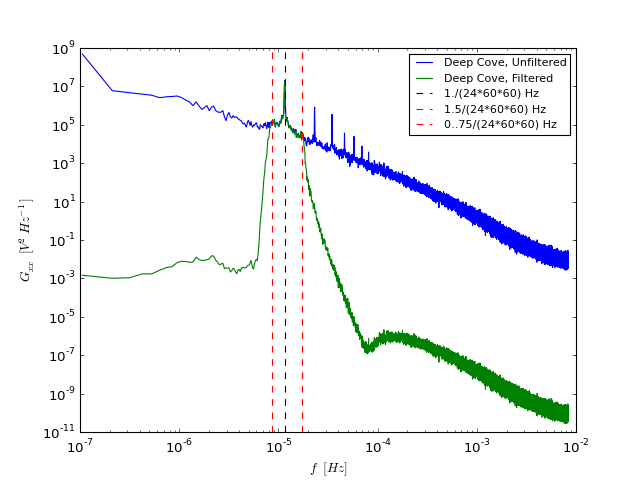

In [255]:
plt.figure()
ax=plt.subplot()
ax.loglog(f,G, label='Deep Cove, Unfiltered')
#ax.loglog(f1,G1, label='Low Pass')
#ax.loglog(f2,G2, label='High Pass')
ax.loglog(f3,G3, label='Deep Cove, Filtered')
#ax.loglog(f4,G4, label='Low a,b with high +low y')
#ax.loglog(f5,G5, label='High a,b with high+low y')
#ax.loglog(f6,G6, label='Low a,b with High y')
ax.axvline(1./sec, label='1./(24*60*60) Hz', linestyle='--', color='k')
ax.axvline(1.5/sec, label='1.5/(24*60*60) Hz', linestyle='--', color='r')
ax.axvline(0.75/sec, label='0..75/(24*60*60) Hz', linestyle='--', color='r')
#ax.axvline(1./60, label='1./60 Hz', linestyle=':', color='r')
#ax.axvline(0.15, label='0.15 Hz', linestyle=':', color='k')
ax.set_xlabel('$f\ \ [Hz]$')
ax.set_ylabel('$G_{xx}\ \ [V^2 Hz^{-1}]$')
ax.legend(loc='best', fontsize='small')

In [220]:
print 'wooooork'

wooooork


**2** Using your band passed signal, plot the *amplitude* of the daily cycle as a function of time, smoothed over a suitable time period. Compare with the raw timeseries to make sure your amplitudes make sense. Comment on the annual variation in the daily amplitude and if it makes sense with respect to the seasons.

In [243]:
#bandpassed signal is yyy
high = signal.argrelmax(yyy)[0]
low = signal.argrelmin(yyy)[0]
#print high,low

maxdc = y[high]
mindc = y[low[0:-1]]
#print maxdc.size,mindc.size
s = mindc.size
#print s
tt = np.arange(s)
dailyamp = np.abs(maxdc-mindc)
#print dailyamp

1130


<IPython.core.display.Javascript object>


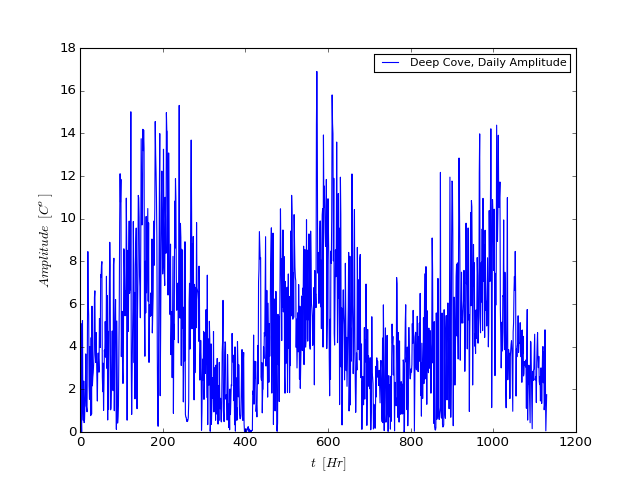

<IPython.core.display.Javascript object>


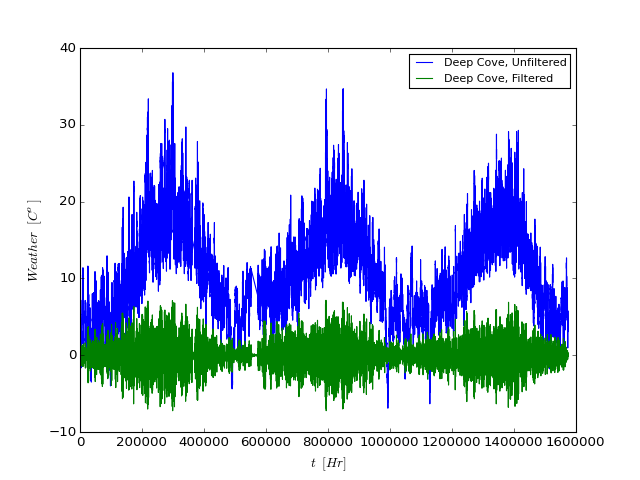

In [247]:
plt.figure()
ax=plt.subplot()
ax.plot(tt,dailyamp, label='Deep Cove, Daily Amplitude')
ax.set_xlabel('$t\ \ [Hr]$')
ax.set_ylabel('$Amplitude\ \ [C^o]$')
ax.legend(loc='best', fontsize='small')

t = np.arange(dc.size)

plt.figure()
ax=plt.subplot()
ax.plot(t,dc, label='Deep Cove, Unfiltered')
ax.plot(t,yyy, label='Deep Cove, Filtered')
ax.set_xlabel('$t\ \ [Hr]$')
ax.set_ylabel('$Weather\ \ [C^o]$')
ax.legend(loc='best', fontsize='small')

The daily amplitude mimicks the raw data, and follows the three humps. This is expected in the daily amplitude however, because if one follows the first graph it can be seen that the maximums on the graph correspond to about noon, supposidly the hottest time of the day. And it is the coldest at midnight. This also agress with the raw data since it follows the maximums as being summer and the minimums being winter. These large increases for noon and summer are expected since the middle of the day is hot (then the night is cold) which results in a larger amplitude. For midnight and winter, there isn;t much variation in temperature so smaller amplitudes are expected here.